# Image segmentation とは
一般的なイメージクラシフィケーションタスクで、ネットワークはそれぞれの入力画像に対してラベルやクラスを割り当てる。しかし、オブジェクトの形、どのピクセルがどのオブジェクトに属しているのかを知りたいときがある。例えばこのような場合は、画像のそれぞれのピクセルにクラスを割り当てる。そしてこのタスクはセグメンテーションとして知られている。セグメンテーションタスクは画像についてのより詳細な情報を返す。そして、セグメンテーションは
医用画像や自動運転、衛星画像などの分野で応用されている。

# 今回使用するデータセットについて

*   Oxford-IIIT Pet Dataset(Parkhi et al, 2012)

このデータセットは37のペットの品種とそれぞれの品種につき200枚の画像から構成されている。
それぞれの画像には一致するラベルとピクセル規模のマスクが含まれている。マスクはピクセルごとのクラスラベル。
それぞれのピクセルは三つのカテゴリが与えられる。


1.   class 1 : ペットに属するピクセル
2.   class 2 : ペットを縁取るピクセル
3.   class 3 : 上記以外、周りのピクセル







In [1]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-wdlitp8d
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-wdlitp8d


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

# データセットをダウンロードする

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

画像の色は0から1に正規化されている。また、セグメンテーションマスクはそれぞれ1,2,3でラベル付けされており、簡単のために1を引き0,1,2にしている。

In [5]:
def normalize(input_image, input_mask):
  input_image  = tf.cast(input_image, tf.float32) / 255.0 #正規化
  input_mask -= 1 #ラベルから1引いて0始まりにする
  return input_image, input_mask

In [6]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'],(128,128)) #128*128にリサイズ
  input_mask = tf.image.resize(datapoint['segmentation_mask'],(128,128))

  input_image, input_mask = normalize(input_image, input_mask) #リサイズした画像を正規化

  return input_image, input_mask

データセットにはすでに訓練とテストに必要なものが揃っているので、同じスプリットを使って進める。

In [7]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [8]:
train_images = dataset['train'].map(load_image, num_parallel_calls = tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls = tf.data.AUTOTUNE)

次のクラスではデータオーギュメンテーションとして、ランダムフリップを実装している。

In [9]:
class Augment(tf.keras.layers.Layer):
  def __init__(self,seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode='horizontal',seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode='horizontal',seed=seed)

  def call(self,inputs,labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

入力パイプラインを作成する、入力のバッチ化した後にデータオーギュメンテーションを施す

In [10]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [11]:
train_images

<ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>

入力画像の可視化

In [12]:
def display(display_list):
  plt.figure(figsize=(15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1,len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    #im = plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
  plt.show()

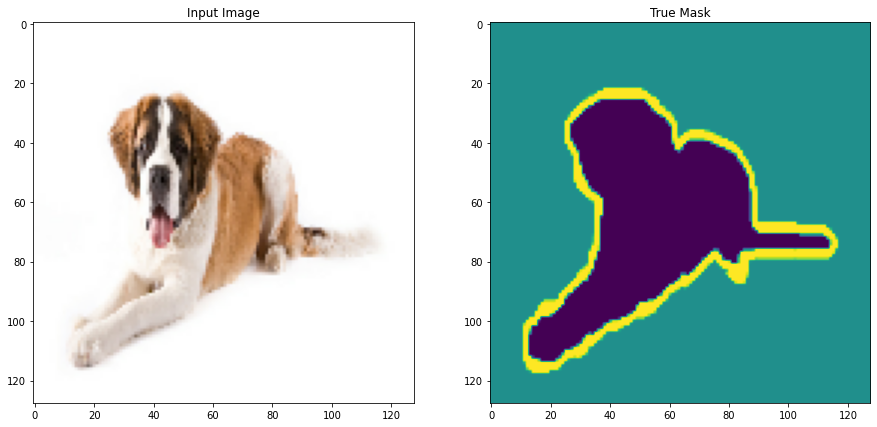

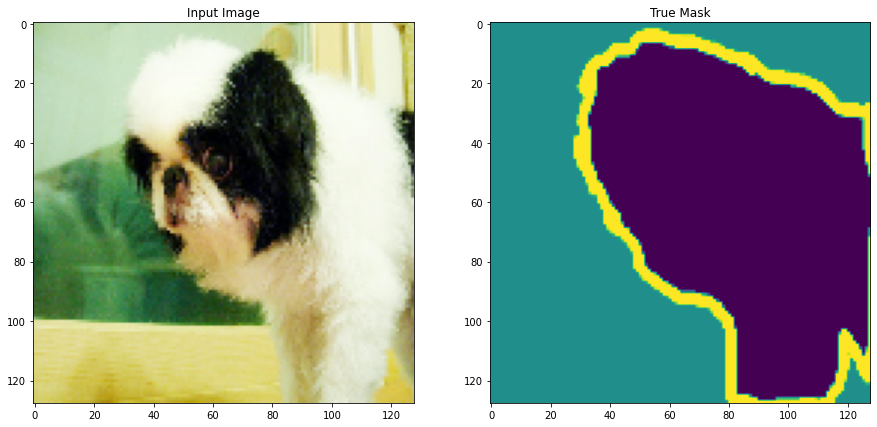

In [13]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

# モデルの定義
今回使用するモデルはU-Netベースで、少し調整したものである。
U-Netはエンコーダとデコーダで構成されている。頑健な特徴を学習し、訓練可能なパラメータの数を減らすために、
事前学習済みのモデル「MobileNetV2」をエンコーダとして使う。デコーダはpix2pixで実装されているアップサンプルブロックを用いる。
また、エンコーダのMobileNetV2は「tf.keras.applications」で利用できる。エンコーダはモデルの中間層からの出力から構成されている。注意したいのが、訓練プロセス中はエンコーダは訓練されない。

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3],include_top=False)

#使用する活性化層
layer_names = [
               'block_1_expand_relu', #64x64
               'block_3_expand_relu', #32x32
               'block_6_expand_relu', #16x16
               'block_13_expand_relu', #8x8
               'block_16_project', #4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

#特徴抽出モデルを作成する
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

デコーダのアップサンプルのブロックはtensorflowの例で実装されているものを使う

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128,128,3])

  #ダウンサンプリング
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  #アップサンプリングとスキップ結合
  for up, skip in zip(up_stack,skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x,skip])
  
  #モデルの最終層
  last = tf.keras.layers.Conv2DTranspose(
      filters= output_channels, kernel_size=3, strides=2,
      padding='same') #64x64 -> 128x128
  #print(last)
  
  x = last(x)
  print(x.shape)

  return tf.keras.Model(inputs=inputs, outputs=x)

# Dice係数を追加する

In [17]:
from keras import backend as K

In [69]:
def dice_coefii(y_true, y_pred):
    y_pred = tf.reshape(y_pred, [-1])
    y_true = tf.reshape(y_true, [-1])
    print(type(y_true),type(y_pred))
    #y_pred  = y_pred.numpy()
    #y_true = y_true.numpy()
    tf.compat.v1.disable_eager_execution()
    new_result = y_pred.eval(session=tf.compat.v1.Session())
    new_result
    y_pred = tf.make_ndarray(y_pred)
    y_true = tf.make_ndarray(y_true)

    intersection = sum(set(y_pred) & set(y_true))

    return 2.0 * intersection / (K.sum(y_true) + K.sum(y_pred))

In [2]:
import numpy as np
import tensorflow as tf
y_p = tf.constant([[1, 2],
                       [5, 6],
                       [9, 10]])
y_t = tf.constant([[6, 7],
                      [10, 11],
                      [14,15]])
y_p = tf.reshape(y_p, [-1])
y_t = tf.reshape(y_t, [-1])
print(type(y_p),type(y_t))

y_p = y_p.numpy()
y_t = y_t.numpy()
print(y_t,y_p)

inte = sum(set(y_t) & set(y_p))
print(inte)

t= K.sum(y_t)
p= K.sum(y_p)
print(t,p)

print(2*inte/(t+p))

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
[ 6  7 10 11 14 15] [ 1  2  5  6  9 10]
16


NameError: ignored

In [21]:
def dice_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    return 2.0 * intersection / (K.sum(y_true) + K.sum(y_pred))

# IoUを追加する

* m : 画像の枚数
* r : 行数
* c : 列数
* n : クラス数


In [22]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [23]:
from sklearn.metrics import f1_score

最終層のフィルターの数は出力層の数とセットである。これはクラスごとの一つの出力となる。

# モデルの訓練をする
コンパイルしてモデルの訓練をする。
マルチクラス分類問題なので、tf.keras.losses.CategoricalCrossentropyロスをfrom_logits=Trueにして使う。そのラベルは各クラスのピクセルごとのスコアのベクトルのかわりとしてスカラーである。
推論の間、ラベルはピクセルに割り当てられ、最も高い値をとるチャネルである。これはcreate_maskで実行できる。

In [24]:
import keras
from keras import optimizers

In [25]:
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [70]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',dice_coefii])


(None, 128, 128, 3)


modelアーキテクチャ↓

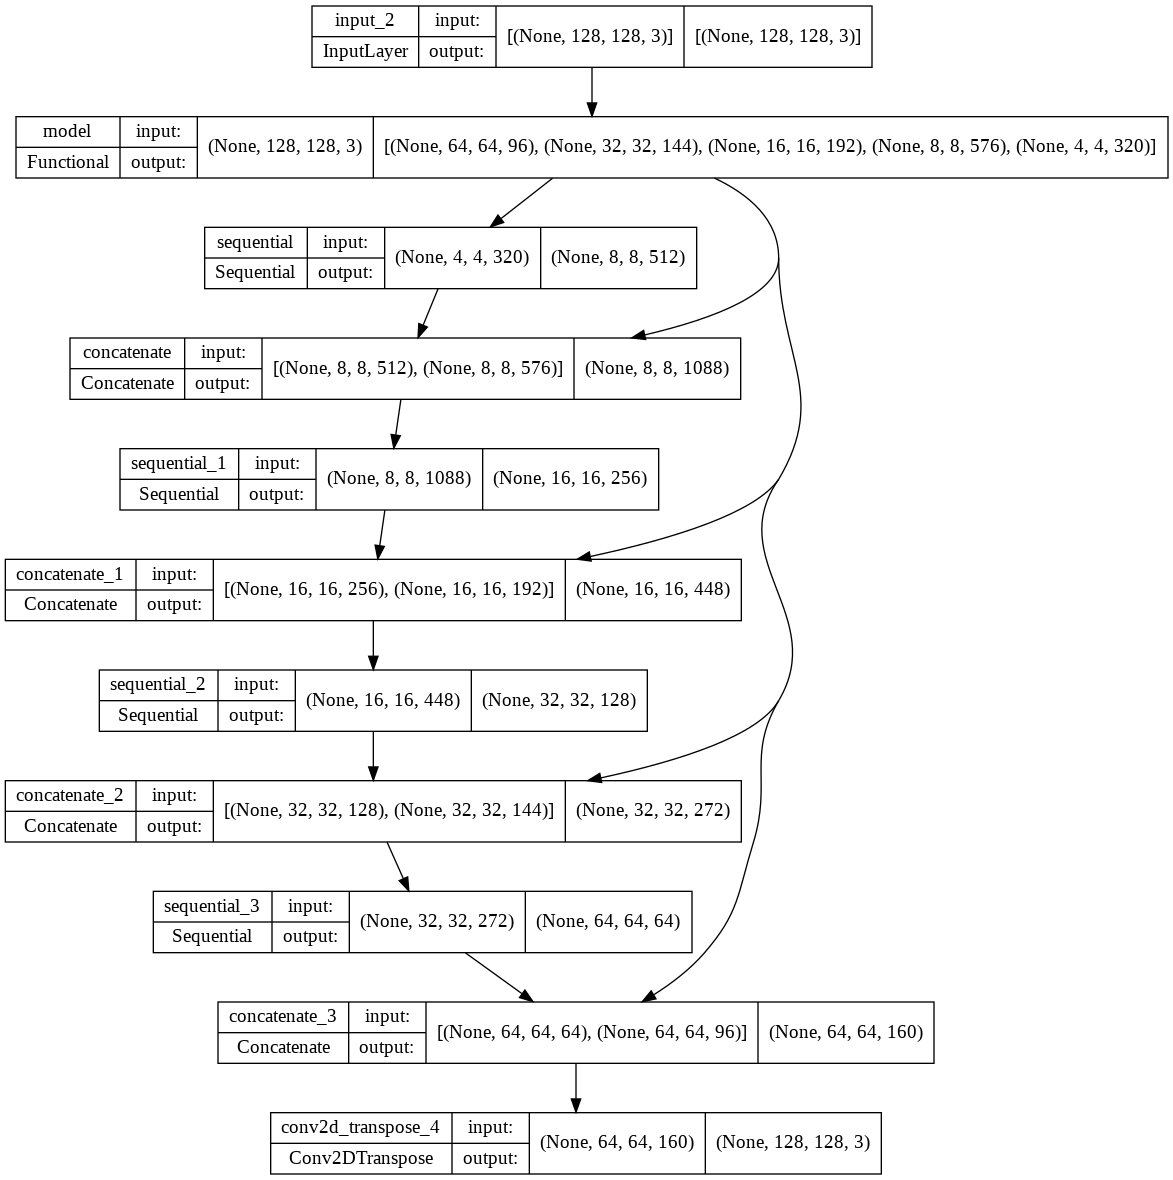

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)

訓練する前にどんなマスクを予測するのかを可視化する。

In [28]:
def create_mask(pred_mask):
  #print(pred_mask.shape)
  pred_mask = tf.argmax(pred_mask, axis=-1)
  #print(pred_mask.shape)
  pred_mask = pred_mask[..., tf.newaxis]

  return pred_mask[0]

In [29]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      #print(pred_mask)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

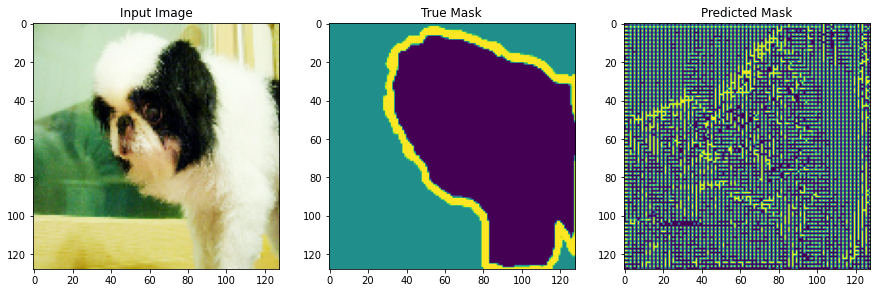

In [30]:
show_predictions()

次に定義するコールバックはモデルが学習中にどのように改善されるかを観察するために使用します。

In [71]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs=None):
    clear_output(wait=True)
    show_predictions()
    print('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [72]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

Epoch 1/10
<class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.framework.ops.Tensor'>


TypeError: ignored

Epoch 1/10
Tensor("Sum_4:0", shape=(), dtype=float32)
Tensor("mul_3:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)

Tensor("Sum_4:0", shape=(), dtype=float32)
Tensor("mul_3:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)

Epoch 1/10
Tensor("mul_2:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Tensor("mul_2:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure()
plt.plot(model_history.epoch, acc, 'r', label='Training acc')
plt.plot(model_history.epoch, val_acc, 'bo', label='Validation acc')
plt.title('Training and Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
val_acc

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
val_loss

In [ ]:
dice = model_history.history['dice_coef']
val_dice = model_history.history['val_dice_coef']
plt.figure()
plt.plot(model_history.epoch, dice, 'r', label='Training dice')
plt.plot(model_history.epoch, val_dice, 'bo', label='Validation dice')
plt.title('Training and Validation Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice coefficient')
plt.ylim([-50, 50])
plt.legend()
plt.show()

dice
[0.7848072648048401,
 0.79147869348526,
 0.7969471216201782,
 0.8008094429969788,
 0.8023466467857361,
 0.8017187714576721,
 0.7995721697807312,
 0.7966639995574951,
 0.793552815914154,
 0.7904639840126038]

In [ ]:
val_dice

5
dice = [-1.3203134536743164,
 -5.978526592254639,
 -32.73757553100586,
 115.77593231201172,
 12.14795207977295]

 loss = [0.6233362555503845,
 0.3144301176071167,
 0.29504072666168213,
 0.28962069749832153,
 0.2876007854938507]
 
 acc = [0.7862510085105896,
 0.8777545690536499,
 0.8812577724456787,
 0.8813766837120056,
 0.8821033239364624]

 10
 dice = [0.4591011703014374,
 0.1171933189034462,
 -0.13343669474124908,
 -0.2848655879497528,
 -0.4034351110458374,
 -0.47410452365875244,
 -0.6244809627532959,
 -0.8425211310386658,
 -0.9093934893608093,
 -0.9774553775787354]

 loss = [0.9050523638725281,
 0.3549919128417969,
 0.2990104854106903,
 0.3089311718940735,
 0.29853522777557373,
 0.2803955376148224,
 0.2844483256340027,
 0.28127792477607727,
 0.2773949205875397,
 0.2679803967475891]

 acc = [0.7220538854598999,
 0.8661302328109741,
 0.8771833777427673,
 0.8709337115287781,
 0.8763927817344666,
 0.8877019286155701,
 0.8848384618759155,
 0.8857287764549255,
 0.8875741362571716,
 0.893125593662262]

 30
 dice = [0.33247679471969604,
 0.044645894318819046,
 -0.08776963502168655,
 -0.5096046924591064,
 -0.5246247053146362,
 -0.787880003452301,
 -0.8151395320892334,
 -0.9062010049819946,
 -1.36659574508667,
 -1.4503947496414185,
 -1.508749008178711,
 -1.8344483375549316,
 -3.063249349594116,
 -3.6320135593414307,
 -4.522680282592773,
 -6.384564399719238,
 -8.55823040008545,
 42.591392517089844,
 -2.5585038661956787,
 -13.4189453125,
 -328.6879577636719,
 8.033452987670898,
 9.704620361328125,
 7.848589897155762,
 6.086905002593994,
 6.118072032928467,
 5.641094207763672,
 5.222050189971924,
 4.884066581726074,
 4.711874961853027]

 loss = [0.41310474276542664,
 0.31457605957984924,
 0.29242753982543945,
 0.29406893253326416,
 0.27540189027786255,
 0.2781718373298645,
 0.27499112486839294,
 0.2685736417770386,
 0.28370147943496704,
 0.26939094066619873,
 0.26734301447868347,
 0.27432873845100403,
 0.28824055194854736,
 0.28892672061920166,
 0.2864256799221039,
 0.29286229610443115,
 0.29113051295280457,
 0.31749188899993896,
 0.3144512474536896,
 0.31795185804367065,
 0.31575489044189453,
 0.32114407420158386,
 0.3385363519191742,
 0.34698477387428284,
 0.3907138705253601,
 0.3717854619026184,
 0.3621812164783478,
 0.37962663173675537,
 0.3838807940483093,
 0.38963615894317627]
 
 acc = [0.8493640422821045,
 0.8760471940040588,
 0.8833585977554321,
 0.8796799182891846,
 0.8886647820472717,
 0.8866716623306274,
 0.8886191844940186,
 0.8922618627548218,
 0.8855615854263306,
 0.8927388787269592,
 0.8931350708007812,
 0.8922651410102844,
 0.8870608806610107,
 0.8908995985984802,
 0.8923394680023193,
 0.8907126784324646,
 0.8920730948448181,
 0.8867899179458618,
 0.8890596628189087,
 0.8916071057319641,
 0.8921633362770081,
 0.889556884765625,
 0.8892704248428345,
 0.890407919883728,
 0.8815500736236572,
 0.8886463642120361,
 0.8903349041938782,
 0.8887323141098022,
 0.8875896334648132,
 0.8877571225166321]

# 予測する

In [ ]:
show_predictions(test_batches, 3)

# オプション
* クラスとクラスの重みが不均一である。
* Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes.(意味がわからない)
* セマンティックセグメンテーションの問題はピクセルごとのクラシフィケーションによって引き起こされる。
* そしてそれは重みを調整し、損失関数を適用することでうまく対処できる。（参考：Classification on imblanced data tutorial）
* 曖昧さを避けるためにmodel.fitはclass_weight argmentの入力（3次元以上）をサポートしていない。
↓エラー例

In [ ]:
　try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

この場合、重さ調節は自分で実装する必要がある。
今回はサンプルの重みを使い実装する、
(data,label)のペアを（data,label,sample_weight）とする。

Model.fitはsample_weightを損失関数と評価指標に伝播する。
sample weightはサンプルの値によってreductionの前にかけられる。


In [ ]:
label = [0,0]
prediction = [[-3,0],[-3,0]]
sample_weight = [1,10]

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction= tf.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

このチュートリアルのためのサンプルウェイトを作るには、(data, label) のペアを受け取り、(data, label, sample_weight) の三つを返す関数が必要です。ここで sample_weight は、各ピクセルのクラス重みを含む1チャンネルの画像。

最もシンプルな実装はclass weightリストのインデックスとしてラベルを用いる方法です。

In [ ]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

完成したデータセットには3枚の画像が含まれている

In [ ]:
train_batches.map(add_sample_weights).element_epec

In [ ]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossEntropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch = 10
)

# 試してみること
* EPOCH数を10,30,50で試してみる（ハイパーパラメータの変更なし）
* :

# 考察
抽出したい物体と、影・他の物体などが重なっているとき、うまく処理できていない。